In [1]:
# pip install shap

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
) 

from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score

In [5]:
from category_encoders import TargetEncoder 
from sklearn.feature_selection import SelectFromModel

In [6]:
# from sklearn.datasets import make_classification

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

In [9]:
from feature_engine.imputation import CategoricalImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

In [10]:
from xgbimputer import XGBImputer

In [11]:
import tqdm as notebook_tqdm

In [12]:
import shap

In [13]:
TrainPre2019 = pd.read_csv('../data/Pre2019_df_Cat9999999.csv')

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_67411/2282598049.py:1: DtypeWarning: Columns (17,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  TrainPre2019 = pd.read_csv('../data/Pre2019_df_Cat9999999.csv')


In [14]:
TrainPre2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949528 entries, 0 to 949527
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0.1                    949528 non-null  int64  
 1   Unnamed: 0                      949528 non-null  int64  
 2   RecordID                        949528 non-null  int64  
 3   ESS_Id                          949528 non-null  int64  
 4   EventTimeStamp                  949528 non-null  object 
 5   eventDescription                902364 non-null  object 
 6   actionDescription               0 non-null       float64
 7   ecuSoftwareVersion              747330 non-null  object 
 8   ecuSerialNumber                 707932 non-null  object 
 9   ecuModel                        900949 non-null  object 
 10  ecuMake                         900949 non-null  object 
 11  ecuSource                       949528 non-null  int64  
 12  spn             

**Goal:** Predict the rank based on the total shots.

In [15]:
TrainPre2019['time_interval_to_SPN5246_class'].value_counts()

time_interval_to_SPN5246_class
9999999    715686
0          229509
1            2233
2            1263
3             837
Name: count, dtype: int64

In [16]:
TrainPre2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,43931,48303,49415,2363162,2015-05-11 13:11:20,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.475814,3276.75,14.4,0.58,639.0_2.0,0,0,301_0,1.027800e+04,0
1,45693,50251,51363,2400445,2015-05-13 08:22:32,Condition Exists Cruise Control Enable Switch,NaN,unknown,unknown,unknown,...,64.637170,3276.75,89.6,4.64,596.0_31.0,0,0,301_0,1.023481e+04,0
2,50271,55260,57330,2482983,2015-05-18 09:34:05,Abnormal Rate of Change Aftertreatment 1 Outle...,NaN,PC4__1284P4C_2*,6U13D13,MX,...,63.525490,3276.75,0.0,20.30,3226.0_10.0,0,0,301_0,1.011362e+04,0
3,54326,59636,61706,2554027,2015-05-21 13:57:35,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.364162,3276.75,12.0,1.45,639.0_2.0,0,0,301_0,1.003723e+04,0
4,54418,59731,61801,2555325,2015-05-21 14:54:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,301_0,1.003628e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949523,4036,4494,4495,1052146,2015-02-24 16:24:05,Low (Severity Medium) Catalyst Tank Level,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,NaN,NaN,NaN,NaN,1761.0_18.0,0,0,R1762_0,2.400000e+08,9999999
949524,5907,6438,6439,1089561,2015-02-26 13:12:11,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,2.058292,3276.75,0.0,0.29,5848.0_9.0,0,0,R1762_0,2.400000e+08,9999999
949525,5915,6446,6447,1090499,2015-02-26 13:50:59,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,NaN,NaN,NaN,NaN,5848.0_9.0,0,0,R1762_0,2.400000e+08,9999999
949526,4472,4952,4953,1059704,2015-02-25 06:08:43,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.378725,3276.75,0.0,1.74,639.0_2.0,0,0,R1764_0,2.400000e+08,9999999



class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [17]:
TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']] = TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']].astype('category')

In [18]:
TrainPre2019[['activeTransitionCount']] = TrainPre2019[['activeTransitionCount']].astype('int')

In [19]:
TrainPre2019.replace(to_replace='3276,75', value='3278.75', inplace=True)

In [20]:
TrainPre2019[[  'AcceleratorPedal',
                    'BarometricPressure',
                    'CruiseControlSetSpeed',
                    'DistanceLtd',
                    'EngineCoolantTemperature',
                    'EngineLoad',
                    'EngineOilPressure',
                    'EngineOilTemperature',
                    'EngineRpm',
                    'EngineTimeLtd',
                    'FuelLevel',
                    'FuelLtd',
                    'FuelRate',
                    'FuelTemperature',
                    'IntakeManifoldTemperature',
                    'Speed',
                    'Throttle',
                    'active',
                    'TurboBoostPressure',
                    'CruiseControlActive',
                    'IgnStatus',
                    'ParkingBrake',
                    'SwitchedBatteryVoltage'
]] = TrainPre2019[[                         'AcceleratorPedal',
                                            'BarometricPressure',
                                            'CruiseControlSetSpeed',
                                            'DistanceLtd',
                                            'EngineCoolantTemperature',
                                            'EngineLoad',
                                            'EngineOilPressure',
                                            'EngineOilTemperature',
                                            'EngineRpm',
                                            'EngineTimeLtd',
                                            'FuelLevel',
                                            'FuelLtd',
                                            'FuelRate',
                                            'FuelTemperature',
                                            'IntakeManifoldTemperature',
                                            'Speed',
                                            'Throttle',
                                            'active',
                                            'TurboBoostPressure',
                                            'CruiseControlActive',
                                            'IgnStatus',
                                            'ParkingBrake',
                                            'SwitchedBatteryVoltage'
                     ]].astype('float64')

In [21]:
NumericColumns = TrainPre2019.select_dtypes(include=[np.number]).columns.tolist()
NumericColumns_Without_MatchID = NumericColumns.pop(0)
NumericColumns

['Unnamed: 0',
 'RecordID',
 'ESS_Id',
 'actionDescription',
 'spn',
 'fmi',
 'active',
 'activeTransitionCount',
 'faultValue',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'FaultId',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure',
 'is_fullderate',
 'is_fullderate_group',
 'time_to_next_SPN5246']

Among numeric columns, will keep:


['AcceleratorPedal',
'BarometricPressure',
'CruiseControlSetSpeed',
'DistanceLtd',
'EngineCoolantTemperature',
'EngineLoad',
'EngineOilPressure',
'EngineOilTemperature',
'EngineRpm',
'EngineTimeLtd',
'FuelLevel',
'FuelLtd',
'FuelRate',
'FuelTemperature',
'IntakeManifoldTemperature',
'Speed',
'Throttle',
'active',
'TurboBoostPressure',
'activeTransitionCount',
'CruiseControlActive',
'IgnStatus',
'ParkingBrake',
'SwitchedBatteryVoltage']

In [22]:
NonNumericColumns = TrainPre2019.select_dtypes(exclude=[np.number]).columns.tolist()
NonNumericColumns

['EventTimeStamp',
 'eventDescription',
 'ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'EquipmentID',
 'LocationTimeStamp',
 'LampStatus',
 'spn_fmi',
 'EquipID_Index',
 'time_interval_to_SPN5246_class']

Among, non-numeric columns, will keep:

        ('target_encoder', TargetEncoder(handle_unknown='ignore'), [   'ecuSoftwareVersion',
                                                                        'ecuSerialNumber',
                                                                        'ecuModel',
                                                                        'ecuMake',
                                                                        'spn_fmi'
                                                                    ]),
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), [   'ecuSource',
                                                                                'LampStatus'
                                                                        ])

In [23]:
X = TrainPre2019.drop(columns = [   'Unnamed: 0',
                                    'Unnamed: 0.1',
                                    'RecordID',
                                    'ESS_Id',
                                    'actionDescription',
                                    'spn',
                                    'fmi',
                                    'faultValue',
                                    'MCTNumber',
                                    'Latitude',
                                    'Longitude',
                                    'is_fullderate',
                                    'is_fullderate_group',
                                    'time_to_next_SPN5246',
                                    'ServiceDistance',
                                    'EventTimeStamp',
                                    'eventDescription',
                                    'EquipmentID',
                                    'LocationTimeStamp',
                                    'EquipID_Index',
                                    'time_interval_to_SPN5246_class',
                                    'MCTNumber',                                  
                                    'FaultId',
                                    'ecuSoftwareVersion',
                                    'ecuSerialNumber',
                                    'ecuModel',
                                    'ecuMake'                                                                                      
                                ]
                      )
y = TrainPre2019['time_interval_to_SPN5246_class']

In [24]:
X['spn_fmi'] = X['spn_fmi'].str.replace('.0', '')

In [25]:
X

,ecuSource,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,11,1.0,127,14.4,13.9200,0.0,0.00000,120841.70,185.0,18.0,...,134.6,1.0,154.4,1279.0,0.0,4.475814,3276.75,14.4,0.58,639_2
1,49,1.0,3,89.6,14.4275,0.0,0.00000,121687.10,186.8,38.0,...,100.4,1.0,120.2,4351.0,0.0,64.637170,3276.75,89.6,4.64,596_31
2,0,1.0,6,0.0,14.3550,0.0,0.00000,123057.10,185.0,0.0,...,120.2,1.0,118.4,17407.0,0.0,63.525490,3276.75,0.0,20.30,3226_10
3,11,1.0,127,12.0,14.5725,0.0,0.00000,124496.50,183.2,14.0,...,109.4,1.0,107.6,1279.0,0.0,4.364162,3276.75,12.0,1.45,639_2
4,11,0.0,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,639_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949523,0,0.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,1761_18
949524,0,1.0,1,0.0,14.2100,0.0,66.48672,80838.70,134.6,11.0,...,32.0,1.0,84.2,17407.0,0.0,2.058292,3276.75,0.0,0.29,5848_9
949525,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,5848_9
949526,11,1.0,127,21.6,14.4275,0.0,66.48672,83681.85,154.4,12.0,...,32.0,1.0,93.2,1279.0,0.0,4.378725,3276.75,0.0,1.74,639_2


In [26]:
X['ecuSource'].value_counts()

ecuSource
0     442543
49    399703
11    101639
3       5118
61       525
Name: count, dtype: int64

In [27]:
y

0               0
1               0
2               0
3               0
4               0
           ...   
949523    9999999
949524    9999999
949525    9999999
949526    9999999
949527    9999999
Name: time_interval_to_SPN5246_class, Length: 949528, dtype: category
Categories (5, int64): [0, 1, 2, 3, 9999999]

In [28]:
X.describe()

,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
count,949528.000000,949528.000000,426247.000000,476659.000000,466508.000000,467458.000000,476568.000000,476625.000000,476168.000000,476735.000000,...,476017.000000,475932.000000,248414.000000,494185.000000,476730.000000,303591.000000,475134.000000,102624.000000,320557.000000,474652.000000
mean,0.520453,77.236872,28.544902,14.191954,0.096682,62.174458,364626.882789,169.566761,31.959878,33.453187,...,50560.896556,4.627839,37.043151,0.995724,106.750817,0.283948,26.293766,3104.761359,66.074916,6.286150
std,0.499582,59.230868,36.550423,1.195484,0.295525,12.239142,142701.441105,32.811442,30.635726,11.282650,...,24171.307050,5.783522,23.152840,0.065249,25.476308,0.450913,28.208800,729.139651,46.345526,8.557188
min,0.000000,0.000000,0.000000,3.045000,0.000000,0.000000,0.000000,-7.600000,0.000000,0.000000,...,0.000000,0.000000,17.600000,0.000000,-40.000000,0.000000,0.000000,7.650000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,14.210000,0.000000,64.622600,267338.900000,170.600000,11.000000,28.420000,...,33494.638645,0.647223,32.000000,1.000000,89.600000,0.000000,0.000000,3276.750000,0.000000,0.580000
50%,1.000000,126.000000,4.000000,14.355000,0.000000,66.486720,379825.250000,183.200000,19.000000,36.540000,...,51938.602972,1.690706,32.000000,1.000000,109.400000,0.000000,9.699216,3276.750000,100.000000,2.030000
75%,1.000000,126.000000,48.800000,14.500000,0.000000,66.486720,481544.650000,186.800000,48.000000,39.440000,...,68751.040705,7.211920,32.000000,1.000000,125.600000,1.000000,59.933190,3276.750000,100.000000,8.700000
max,1.000000,127.000000,100.000000,15.225000,1.000000,69.593570,649549.000000,406.400000,101.000000,145.000000,...,312737.574126,25.611560,231.800000,1.000000,264.200000,1.000000,158.447200,3278.750000,100.000000,63.220000


In [29]:
X

le_y = LabelEncoder()

y_fitted = le_y.fit(y)
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.001, random_state = 321, shuffle=True, stratify = y_encoded)


# Apply SMOTE
smote = SMOTE(random_state=3434)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)    # might need another set of pipeline; alternatively, we can go with the following approach:

In [30]:
 

ct0 = ColumnTransformer(
        [('target_encoder', TargetEncoder(handle_unknown='ignore'), ['spn_fmi',
                                                                     'ecuSource',
                                                                     'LampStatus',
                                                                    ]
          )],
        remainder='passthrough')
        



xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor0', ct0),
        ('StandardScaler', StandardScaler()),
        ('imputer', IterativeImputer(estimator = HistGradientBoostingRegressor(verbose=2, random_state=434), max_iter=100, random_state=343)),
        ('smote', SMOTE(random_state=344)),
        ('xgbc', XGBClassifier( # tree_method = "hist",                                
                               enable_categorical=True, 
                                eval_metric='mlogloss',
                                objective = 'multi:softmax',
                                num_class = 5,
                                device = "cuda",
                                random_state = 535                         
                            )
        )
    ]
).fit(X_train, y_train) 

y_pred = xgbc_pipe.predict(X_test)  





Binning 0.178 GB of training data: 0.277 s
Binning 0.020 GB of validation data: 0.041 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.44640, val loss: 0.45023, in 0.158s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.40335, val loss: 0.40682, in 0.380s
[3/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.36823, val loss: 0.37140, in 0.323s
[4/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.33971, val loss: 0.34271, in 0.205s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.31557, val loss: 0.31836, in 0.136s
[6/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.29581, val loss: 0.29842, in 0.166s
[7/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.27977, val loss: 0.28228, in 0.187s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.26667, val loss: 0.26909, in 0.075s
[9/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.25569, val loss: 0.25796, in 0.062s
[10/100] 1 tree, 31 leaves, max depth = 9, train l

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/bentonwang/Library/Python/3.13/lib/python/site-packages/xgboost/training.py:183: UserWarning: [00:20:01] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


~ For Ref / Backup purposes ~


ct1 = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [  'AcceleratorPedal',
                                        'BarometricPressure',
                                        'CruiseControlSetSpeed',
                                        'DistanceLtd',
                                        'EngineCoolantTemperature',
                                        'EngineLoad',
                                        'EngineOilPressure',
                                        'EngineOilTemperature',
                                        'EngineRpm',
                                        'EngineTimeLtd',
                                        'FuelLevel',
                                        'FuelLtd',
                                        'FuelRate',
                                        'FuelTemperature',
                                        'IntakeManifoldTemperature',
                                        'Speed',
                                        'Throttle',
                                        'active',
                                        'TurboBoostPressure',
                                        'CruiseControlActive',
                                        'IgnStatus',
                                        'ParkingBrake',
                                        'SwitchedBatteryVoltage'
                                        ]),

         ('num_imputer', IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=10, random_state=343), [ 
                                        'AcceleratorPedal',
                                        'BarometricPressure',
                                        'CruiseControlSetSpeed',
                                        'DistanceLtd',
                                        'EngineCoolantTemperature',
                                        'EngineLoad',
                                        'EngineOilPressure',
                                        'EngineOilTemperature',
                                        'EngineRpm',
                                        'EngineTimeLtd',
                                        'FuelLevel',
                                        'FuelLtd',
                                        'FuelRate',
                                        'FuelTemperature',
                                        'IntakeManifoldTemperature',
                                        'Speed',
                                        'Throttle',
                                        'active',
                                        'TurboBoostPressure',
                                        'CruiseControlActive',
                                        'IgnStatus',
                                        'ParkingBrake',
                                        'SwitchedBatteryVoltage',
                                        'spn_fmi',
                                        'ecuSource',
                                        'LampStatus',
                                        'activeTransitionCount'
                                        ]) 
    ],
    remainder='passthrough'
)

~ For Ref / Backup purposes ~


xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor0', ct0),
        ('StandardScaler', StandardScaler()),
        ('imputer', IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=10, random_state=343)),
        ('smote', SMOTE(random_state=3434)),
        ('xgbc', XGBClassifier( enable_categorical=True, 
                               # max_cat_to_onehot=1,
                                booster='gbtree', 
                                eval_metric='mlogloss',
                                objective = 'multi:softprob'
                            )
        )
    ]
).fit(X_train, y_train) 

y_pred = xgbc_pipe.predict(X_test)  

~ For Ref / Backup purposes ~

Other imputer methodologies to try: XGBImputer(), GradientBoostingRegressor(), ExtraTreesRegressor()

In [31]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 3.0094736842105263
RMSE: 1.7347834689696944
MAE: 0.7821052631578947
MAPE: 1298932945157385.2
R2: -0.023067949521038855


xgb = XGBClassifier(
                    eval_metric='mlogloss'
                    
                    ).fit(X_train, y_train)

In [32]:
le_y

LabelEncoder()

In [33]:
y_fitted

LabelEncoder()

In [34]:
y_encoded

array([0, 0, 0, ..., 4, 4, 4], shape=(949528,))

In [35]:
y

0               0
1               0
2               0
3               0
4               0
           ...   
949523    9999999
949524    9999999
949525    9999999
949526    9999999
949527    9999999
Name: time_interval_to_SPN5246_class, Length: 949528, dtype: category
Categories (5, int64): [0, 1, 2, 3, 9999999]


#RandomizedSearchCV

param_dist = {
    'max_depth': range(1, 10, 1),
    'min_child_weight':range(1, 6, 1),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample':[i/10.0 for i in range(1, 10)],
    'colsample_bytree':[i/10.0 for i in range(1, 10)],
    'n_estimators':stats.randint(1, 70),
    'gamma':[i/10.0 for i in range(0, 5)],
   # 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
    
}



# xgb_model = XGBClassifier()

# Create the RandomizedSearchCV object
cv = RepeatedStratifiedKFold(n_splits=10, shuffle=True, random_state=343)
random_search = RandomizedSearchCV(xgbc_pipe[1], param_distributions=param_dist, n_iter=20, cv=cv, scoring='precision_macro', verbose=2, n_jobs=-1, random_state=321)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)






In [36]:
accuracy_score(y_test, y_pred)

0.7894736842105263

In [37]:
confusion_matrix(y_test, y_pred)

array([[155,   8,   1,   0,  66],
       [  0,   1,   0,   0,   1],
       [  0,   0,   1,   0,   0],
       [  0,   0,   0,   1,   0],
       [ 98,  22,   4,   0, 592]])

In [38]:
print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       230
           1       0.03      0.50      0.06         2
           2       0.17      1.00      0.29         1
           3       1.00      1.00      1.00         1
           4       0.90      0.83      0.86       716

    accuracy                           0.79       950
   macro avg       0.54      0.80      0.57       950
weighted avg       0.83      0.79      0.81       950



cv = LeaveOneOut()
scores = cross_val_score(xgbc_pipe, X_test, y_test, cv=10, scoring='recall_macro')

print('Cross Validation Macro Precision Scores:', scores)

### Top Features' Importance

selection = SelectFromModel(xgbc_pipe[1], threshold=0.0001, prefit=True)

X_selected = selection.transform(X_train)
X_selected

plot_importance_object = plot_importance(xgbc_pipe[1], importance_type='gain')
plt.title('Feature Importance for Full Derate Prediction')
plt.show()

feature_importances = xgbc_pipe[1].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_27_features = feature_importance_df.head(27)

print(top_27_features)

print("Top 27 features:", top_27_features['Feature'].tolist())

### Import fresh test data (previously held out) for a fresh round of testing 

In [39]:
test = pd.read_csv('../data/In2019_df_Cat9999999.csv') 

In [40]:
FreshTest_In2019 = test
FreshTest_In2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,952775,1062090,1104925,73930906,2019-01-11 12:51:18,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,96.0_3.0,0,1,301_1,239999976.0,9999999
1,952776,1062091,1104926,73930907,2019-01-11 12:51:18,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,829.0_3.0,0,1,301_1,239999976.0,9999999
2,952781,1062096,1104931,73934247,2019-01-11 13:11:40,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,96.0_3.0,0,1,301_1,239999976.0,9999999
3,952782,1062097,1104932,73934248,2019-01-11 13:11:40,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,829.0_3.0,0,1,301_1,239999976.0,9999999
4,952809,1062135,1104970,73942005,2019-01-11 13:13:38,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,0.00000,NaN,0.0,1.16,96.0_3.0,0,1,301_1,239999976.0,9999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,977126,1089938,1137548,80503703,2019-03-16 11:22:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,105437340_0,239999976.0,9999999
112015,977150,1089962,1137572,80509396,2019-03-16 11:24:04,Special Instructions Engine Starter Solenoid L...,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,1321.0_14.0,0,0,105437340_0,239999976.0,9999999
112016,977151,1089963,1137573,80509397,2019-03-16 11:27:41,NaN,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,520321.0_13.0,0,0,105437340_0,239999976.0,9999999
112017,978491,1091502,1139112,80907838,2019-03-20 10:57:34,Special Instructions Engine Starter Solenoid L...,NaN,NaN,K1243673,FAOM-xx810S-EC3,...,NaN,NaN,NaN,NaN,1321.0_14.0,0,0,105437340_0,239999976.0,9999999


In [41]:
FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']] = FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']].astype('category')

In [42]:
FreshTest_In2019[['activeTransitionCount']] = FreshTest_In2019[['activeTransitionCount']].astype('int')

In [43]:
X_fresh_test = FreshTest_In2019.drop(columns = [    'Unnamed: 0',
                                                    'Unnamed: 0.1',
                                                    'RecordID',
                                                    'ESS_Id',
                                                    'actionDescription',
                                                    'spn',
                                                    'fmi',
                                                    'faultValue',
                                                    'MCTNumber',
                                                    'Latitude',
                                                    'Longitude',
                                                    'is_fullderate',
                                                    'is_fullderate_group',
                                                    'time_to_next_SPN5246',
                                                    'ServiceDistance',
                                                    'EventTimeStamp',
                                                    'eventDescription',
                                                    'EquipmentID',
                                                    'LocationTimeStamp',
                                                    'EquipID_Index',
                                                    'time_interval_to_SPN5246_class',
                                                    'MCTNumber',                                  
                                                    'FaultId',
                                                    'ecuSoftwareVersion',
                                                    'ecuSerialNumber',
                                                    'ecuModel',
                                                    'ecuMake'  
                                                    ]
                                     )  
X_fresh_test

,ecuSource,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,49,True,126,34.0,14.5,False,0.0,389864.2,145.4,46.0,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,96.0_3.0
1,49,True,126,34.0,14.5,False,0.0,389864.2,145.4,46.0,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,829.0_3.0
2,49,False,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,96.0_3.0
3,49,False,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,829.0_3.0
4,49,True,126,0.0,14.5,False,0.0,389870.2,156.2,13.0,...,87.8,True,107.6,1279.0,True,0.00000,NaN,0.0,1.16,96.0_3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,11,False,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,50175.0,NaN,NaN,NaN,NaN,NaN,639.0_2.0
112015,3,True,1,0.0,14.5,False,0.0,147893.8,82.4,25.0,...,NaN,True,68.0,63487.0,True,0.00000,NaN,100.0,0.29,1321.0_14.0
112016,3,True,4,0.0,14.5,False,0.0,147893.8,91.4,24.0,...,NaN,True,73.4,63487.0,True,0.00000,NaN,100.0,0.29,520321.0_13.0
112017,3,False,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,63487.0,NaN,NaN,NaN,NaN,NaN,1321.0_14.0


In [44]:
X_fresh_test['spn_fmi'] = X_fresh_test['spn_fmi'].str.replace('.0', '')

In [45]:
X_fresh_test.shape

(112019, 27)

X_FreshTest_Transformed = ct.transform(X_fresh_test)
X_FreshTest_Transformed

In [46]:
y_fresh_pred = xgbc_pipe.predict(X_fresh_test)

In [47]:
y_fresh_pred

array([0, 0, 4, ..., 4, 4, 4], shape=(112019,), dtype=int32)

In [48]:
y_fresh_pred_series = pd.Series(y_fresh_pred)
y_fresh_pred_series

0         0
1         0
2         4
3         4
4         0
         ..
112014    4
112015    4
112016    4
112017    4
112018    4
Length: 112019, dtype: int32

In [49]:
In2019_withFresh_Y_Pred = pd.concat([FreshTest_In2019, y_fresh_pred_series], axis=1)
In2019_withFresh_Y_Pred.rename(columns={In2019_withFresh_Y_Pred.columns[-1]: 'Predicted_Time_Interval_Class'}, inplace=True)
In2019_withFresh_Y_Pred  

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class,Predicted_Time_Interval_Class
0,952775,1062090,1104925,73930906,2019-01-11 12:51:18,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,34.4,13.05,96.0_3.0,0,1,301_1,239999976.0,9999999,0
1,952776,1062091,1104926,73930907,2019-01-11 12:51:18,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,34.4,13.05,829.0_3.0,0,1,301_1,239999976.0,9999999,0
2,952781,1062096,1104931,73934247,2019-01-11 13:11:40,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,96.0_3.0,0,1,301_1,239999976.0,9999999,4
3,952782,1062097,1104932,73934248,2019-01-11 13:11:40,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,829.0_3.0,0,1,301_1,239999976.0,9999999,4
4,952809,1062135,1104970,73942005,2019-01-11 13:13:38,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,0.0,1.16,96.0_3.0,0,1,301_1,239999976.0,9999999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,977126,1089938,1137548,80503703,2019-03-16 11:22:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,...,NaN,NaN,NaN,639.0_2.0,0,0,105437340_0,239999976.0,9999999,4
112015,977150,1089962,1137572,80509396,2019-03-16 11:24:04,Special Instructions Engine Starter Solenoid L...,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,NaN,100.0,0.29,1321.0_14.0,0,0,105437340_0,239999976.0,9999999,4
112016,977151,1089963,1137573,80509397,2019-03-16 11:27:41,NaN,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,NaN,100.0,0.29,520321.0_13.0,0,0,105437340_0,239999976.0,9999999,4
112017,978491,1091502,1139112,80907838,2019-03-20 10:57:34,Special Instructions Engine Starter Solenoid L...,NaN,NaN,K1243673,FAOM-xx810S-EC3,...,NaN,NaN,NaN,1321.0_14.0,0,0,105437340_0,239999976.0,9999999,4


In [50]:
In2019_withFresh_Y_Pred.to_csv('../data/In2019_withFresh_Y_Pred_TimeIntervalClass.csv')

In [51]:
y_fresh_test = FreshTest_In2019['time_interval_to_SPN5246_class']

In [52]:
y_fresh_test_encoded = le_y.transform(y_fresh_test)

In [53]:
accuracy_score(y_fresh_test_encoded, y_fresh_pred)

0.8742534748569439

In [54]:
confusion_matrix(y_fresh_test_encoded, y_fresh_pred)

array([[   99,   176,   148,     0,  1690],
       [   20,   131,    61,     0,    99],
       [    9,    33,    67,     0,    31],
       [    0,     0,     0,   101,     0],
       [ 7493,  2521,  1790,    15, 97535]])

In [55]:
print(classification_report(y_fresh_test_encoded, y_fresh_pred, zero_division = 0)) 

              precision    recall  f1-score   support

           0       0.01      0.05      0.02      2113
           1       0.05      0.42      0.08       311
           2       0.03      0.48      0.06       140
           3       0.87      1.00      0.93       101
           4       0.98      0.89      0.93    109354

    accuracy                           0.87    112019
   macro avg       0.39      0.57      0.41    112019
weighted avg       0.96      0.87      0.91    112019



In [56]:
y_fresh_test_encoded.tolist()

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [57]:
y_fresh_pred.tolist()

[0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 0,
 1,
 4,
 4,
 1,
 4,
 0,
 0,
 1,
 1,
 4,
 1,
 4,
 0,
 2,
 4,


In [58]:
print(f'MSE: {mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'RMSE: {root_mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAE: {mean_absolute_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'R2: {r2_score(y_fresh_test_encoded, y_fresh_pred)}') 

MSE: 1.595488265383551
RMSE: 1.2631263853564103
MAE: 0.4361135164570296
MAPE: 290754537222644.6
R2: -3.9077914456404885


fresh_cv = LeaveOneOut()
fresh_CV_scores = cross_val_score(xgbc_pipe, X_fresh_test, y_fresh_test_encoded, cv=10, scoring='recall_macro')

print('Cross Validation Macro Precision Scores:', fresh_CV_scores)

In [59]:
# submission.to_csv('../data/submission_XGBClassifier_TunedHyperparameter_TargetEncoder_LearningRatePt05_MaxTreeDepth5_MinChild1_Estimators199_TestSizePt001_MostFeatures_ExcludingMapCode.csv', index = False)

In [60]:
xgbc_pipe_XGBClassifier = xgbc_pipe[:-2]
xgbc_pipe_XGBClassifier

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor0',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(handle_unknown='ignore'),
                                                  ['spn_fmi', 'ecuSource',
                                                   'LampStatus'])])),
                ('StandardScaler', StandardScaler()),
                ('imputer',
                 IterativeImputer(estimator=HistGradientBoostingRegressor(random_state=434,
                                                                          verbose=2),
                                  max_iter=1, random_state=343))])

In [61]:
X_fresh_test_transformed_SHAP = xgbc_pipe_XGBClassifier.transform(X_fresh_test)
X_fresh_test_transformed_SHAP  


array([[-0.31362769,  0.93956627,  0.71840083, ..., -2.57227923,
        -0.68353557,  0.79039081],
       [-0.08170154,  0.93956627,  0.71840083, ..., -2.57227923,
        -0.68353557,  0.79039081],
       [-0.31362769,  0.93956627,  0.99633443, ...,  0.20777049,
         0.56057869, -0.1538777 ],
       ...,
       [ 0.21877928,  0.61415514, -1.16883415, ..., -3.66910822,
         0.73195563, -0.70073344],
       [ 1.39907578,  0.61415514, -1.16883415, ..., -3.53981079,
         0.77176932, -0.21972343],
       [ 0.60687952,  0.61415514,  0.99633443, ..., -2.8240786 ,
         0.57052342, -0.1348689 ]], shape=(112019, 27))

In [62]:
explainer = shap.TreeExplainer(xgbc_pipe[4])
explanation = explainer(xgbc_pipe[:-2].transform(X_fresh_test))

In [63]:
explainer.shap_values(xgbc_pipe[:-2].transform(X_fresh_test))

array([[[-1.57910481e-01,  1.11645080e-01,  3.06851298e-01,
         -6.95751858e+00, -3.91815573e-01],
        [ 9.13087353e-02, -3.72375786e-01, -7.46832132e-01,
         -6.17797792e-01,  1.35994419e-01],
        [-4.61346149e-01, -2.00186744e-01,  4.04035747e-01,
         -2.32549921e-01, -2.71557242e-01],
        ...,
        [-7.08207488e-02,  7.64839258e-03,  1.94481716e-01,
         -1.04467534e-01,  4.01317850e-02],
        [ 1.28861442e-02, -8.22290927e-02,  4.40209359e-02,
          3.09619494e-02,  1.38547635e-02],
        [ 3.65199484e-02, -6.31042644e-02,  7.96033186e-04,
          4.81110364e-02,  3.30564864e-02]],

       [[-2.10472465e-01, -7.10631460e-02,  7.89644495e-02,
         -6.95407391e+00, -3.55116010e-01],
        [ 6.30204752e-02, -2.75294751e-01, -7.25714326e-01,
         -6.17797792e-01,  1.20120697e-01],
        [-4.73126769e-01, -9.15391967e-02,  4.58329022e-01,
         -2.31466010e-01, -2.80904174e-01],
        ...,
        [-6.53922260e-02,  1.6415199

In [64]:
explanation[:,:,1]

.values =
array([[ 0.11164508, -0.3723758 , -0.20018674, ...,  0.00764839,
        -0.08222909, -0.06310426],
       [-0.07106315, -0.27529475, -0.0915392 , ...,  0.0164152 ,
        -0.09257436, -0.06358019],
       [ 0.05145591, -0.51589453, -0.1581203 , ..., -0.09751994,
        -0.04028532, -0.01654823],
       ...,
       [-0.25274   ,  0.08194115, -0.03603932, ...,  0.05633955,
        -0.0457425 ,  0.23285517],
       [-0.37963477,  0.03705475,  0.11854922, ...,  0.04494146,
        -0.02614673,  0.22863969],
       [-0.41303125,  0.09556349, -0.00697619, ...,  0.01302669,
        -0.09075357, -0.00746393]], shape=(112019, 27), dtype=float32)

.base_values =
array([0.5217496, 0.5217496, 0.5217496, ..., 0.5217496, 0.5217496,
       0.5217496], shape=(112019,), dtype=float32)

.data =
array([[-0.31362769,  0.93956627,  0.71840083, ..., -2.57227923,
        -0.68353557,  0.79039081],
       [-0.08170154,  0.93956627,  0.71840083, ..., -2.57227923,
        -0.68353557,  0.79039081],

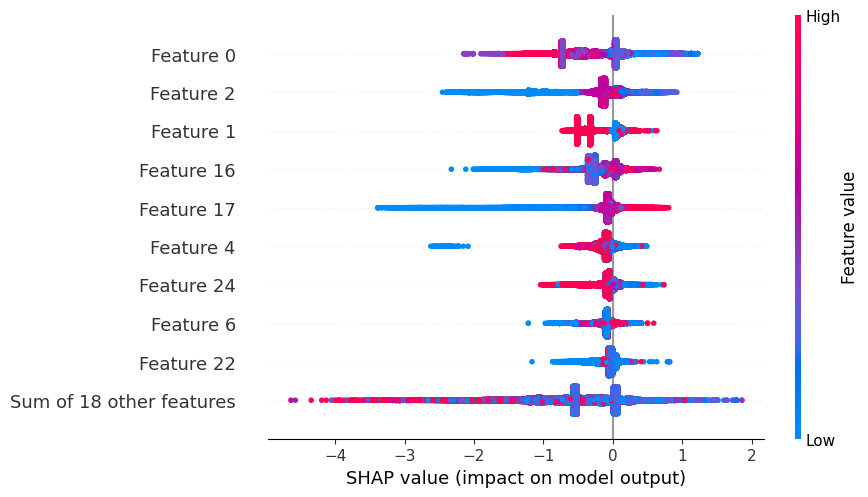

In [65]:
shap.plots.beeswarm(explanation[:,:,1])

In [66]:
xgbc_pipe[:-1].get_feature_names_out()[[0, 2, 1, 16, 17, 4, 24, 6, 22]].tolist()

['target_encoder__spn_fmi',
 'target_encoder__LampStatus',
 'target_encoder__ecuSource',
 'remainder__FuelLevel',
 'remainder__FuelLtd',
 'remainder__activeTransitionCount',
 'remainder__SwitchedBatteryVoltage',
 'remainder__BarometricPressure',
 'remainder__ParkingBrake']

In [67]:
feature_names = xgbc_pipe[:-1].get_feature_names_out(input_features=X_fresh_test.columns)
feature_names

array(['target_encoder__spn_fmi', 'target_encoder__ecuSource',
       'target_encoder__LampStatus', 'remainder__active',
       'remainder__activeTransitionCount', 'remainder__AcceleratorPedal',
       'remainder__BarometricPressure', 'remainder__CruiseControlActive',
       'remainder__CruiseControlSetSpeed', 'remainder__DistanceLtd',
       'remainder__EngineCoolantTemperature', 'remainder__EngineLoad',
       'remainder__EngineOilPressure', 'remainder__EngineOilTemperature',
       'remainder__EngineRpm', 'remainder__EngineTimeLtd',
       'remainder__FuelLevel', 'remainder__FuelLtd',
       'remainder__FuelRate', 'remainder__FuelTemperature',
       'remainder__IgnStatus', 'remainder__IntakeManifoldTemperature',
       'remainder__ParkingBrake', 'remainder__Speed',
       'remainder__SwitchedBatteryVoltage', 'remainder__Throttle',
       'remainder__TurboBoostPressure'], dtype=object)

In [68]:
df_SHAP = pd.DataFrame(X_fresh_test_transformed_SHAP, columns=feature_names)
df_SHAP

,target_encoder__spn_fmi,target_encoder__ecuSource,target_encoder__LampStatus,remainder__active,remainder__activeTransitionCount,remainder__AcceleratorPedal,remainder__BarometricPressure,remainder__CruiseControlActive,remainder__CruiseControlSetSpeed,remainder__DistanceLtd,...,remainder__FuelLtd,remainder__FuelRate,remainder__FuelTemperature,remainder__IgnStatus,remainder__IntakeManifoldTemperature,remainder__ParkingBrake,remainder__Speed,remainder__SwitchedBatteryVoltage,remainder__Throttle,remainder__TurboBoostPressure
0,-0.313628,0.939566,0.718401,0.959961,0.823273,0.149192,0.257652,-0.327107,-5.080005,0.176913,...,0.159292,0.533568,1.492480,0.065533,-0.885225,-0.629743,0.717017,-2.572279,-0.683536,0.790391
1,-0.081702,0.939566,0.718401,0.959961,0.823273,0.149192,0.257652,-0.327107,-5.080005,0.176913,...,0.159292,0.533568,1.492480,0.065533,-0.885225,-0.629743,0.717017,-2.572279,-0.683536,0.790391
2,-0.313628,0.939566,0.996334,-1.041709,0.823273,0.077723,-2.374764,-0.328080,-0.096939,-0.064348,...,0.000311,-0.156916,-0.217782,-0.294386,-0.067072,-0.151159,-0.359365,0.207770,0.560579,-0.153878
3,-0.081702,0.939566,0.996334,-1.041709,0.823273,0.077723,-2.374764,-0.328080,-0.096130,-0.064348,...,0.000311,-0.156916,-0.217782,-0.364839,-0.053641,-0.151159,-0.359365,0.230258,0.560579,-0.146075
4,-0.313628,0.939566,0.718401,0.959961,0.823273,-0.781019,0.257652,-0.327107,-5.080005,0.176955,...,0.159325,-0.553551,2.192141,0.065533,0.033294,1.587949,-0.932107,-0.484626,-1.425805,-0.599066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112014,0.857778,0.919157,1.921529,-1.041709,0.840156,0.183192,-2.393848,-0.327117,-0.074737,0.197247,...,0.170867,-0.147150,-0.216555,-1.910470,0.010355,-0.532319,-0.256267,-0.148511,0.680136,-0.140002
112015,1.399076,0.614155,-1.168834,0.959961,-1.287107,-0.781019,0.257652,-0.327107,-5.080005,-1.518699,...,-1.338084,-0.622067,-0.224315,0.065533,-1.521122,1.587949,-0.932107,-3.690600,0.731956,-0.700733
112016,0.218779,0.614155,-1.168834,0.959961,-1.236458,-0.781019,0.257652,-0.327107,-5.080005,-1.518699,...,-1.338084,-0.635770,-0.200330,0.065533,-1.309156,1.587949,-0.932107,-3.669108,0.731956,-0.700733
112017,1.399076,0.614155,-1.168834,-1.041709,-1.219575,-0.045966,-6.023911,-0.147328,-0.081609,-0.096783,...,0.164327,-0.165166,-0.182169,-1.926706,-0.006721,-0.404436,-0.055767,-3.539811,0.771769,-0.219723


In [69]:
# shap.plots.beeswarm(explanation, df_SHAP)

In [70]:
xgbc_pipe[:-1].get_feature_names_out()

array(['target_encoder__spn_fmi', 'target_encoder__ecuSource',
       'target_encoder__LampStatus', 'remainder__active',
       'remainder__activeTransitionCount', 'remainder__AcceleratorPedal',
       'remainder__BarometricPressure', 'remainder__CruiseControlActive',
       'remainder__CruiseControlSetSpeed', 'remainder__DistanceLtd',
       'remainder__EngineCoolantTemperature', 'remainder__EngineLoad',
       'remainder__EngineOilPressure', 'remainder__EngineOilTemperature',
       'remainder__EngineRpm', 'remainder__EngineTimeLtd',
       'remainder__FuelLevel', 'remainder__FuelLtd',
       'remainder__FuelRate', 'remainder__FuelTemperature',
       'remainder__IgnStatus', 'remainder__IntakeManifoldTemperature',
       'remainder__ParkingBrake', 'remainder__Speed',
       'remainder__SwitchedBatteryVoltage', 'remainder__Throttle',
       'remainder__TurboBoostPressure'], dtype=object)

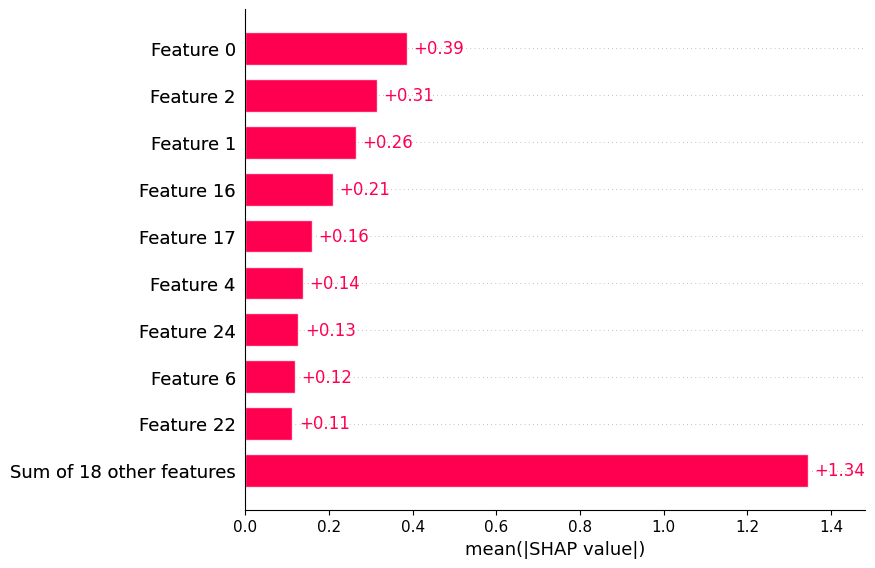

In [71]:
shap.plots.bar(explanation[:,:,1])

# Top Features' Importance

In [72]:
selection = SelectFromModel(xgbc_pipe[4], threshold=0.0001, prefit=True)

In [73]:
X_selected = selection.transform(X_train)
X_selected

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[49, 1.0, 126, ..., 100.0, 0.58, '929_9'],
       [0, 1.0, 1, ..., nan, 29.0, '111_17'],
       [49, 1.0, 126, ..., 0.0, 0.58, '929_9'],
       ...,
       [0, 0.0, 15, ..., nan, nan, '91_8'],
       [49, 1.0, 126, ..., 100.0, 13.05, '96_4'],
       [0, 1.0, 1, ..., nan, 8.99, '111_17']],
      shape=(948578, 27), dtype=object)

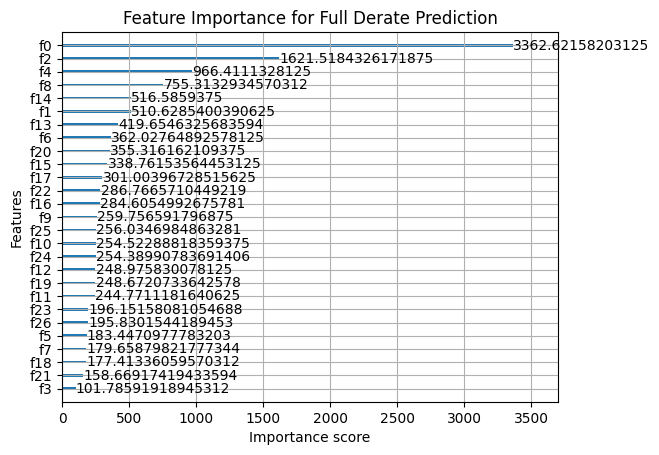

In [74]:
plot_importance_object = plot_importance(xgbc_pipe[4], importance_type='gain')
plt.title('Feature Importance for Full Derate Prediction')
plt.show()

In [75]:
feature_importances = xgbc_pipe[4].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_27_features = feature_importance_df.head(27)

print(top_27_features)

                      Feature  Importance
0                   ecuSource    0.257844
2       activeTransitionCount    0.124337
4          BarometricPressure    0.074104
8    EngineCoolantTemperature    0.057917
14                  FuelLevel    0.039612
1                      active    0.039155
13              EngineTimeLtd    0.032179
6       CruiseControlSetSpeed    0.027760
20                 LampStatus    0.027245
15                    FuelLtd    0.025976
17            FuelTemperature    0.023081
22                      Speed    0.021989
16                   FuelRate    0.021823
9                  EngineLoad    0.019918
25         TurboBoostPressure    0.019633
10          EngineOilPressure    0.019517
24                   Throttle    0.019506
12                  EngineRpm    0.019091
19  IntakeManifoldTemperature    0.019068
11       EngineOilTemperature    0.018769
23     SwitchedBatteryVoltage    0.015041
26                    spn_fmi    0.015016
5         CruiseControlActive    0

In [76]:
print("Top 27 features:", top_27_features['Feature'].tolist())

Top 27 features: ['ecuSource', 'activeTransitionCount', 'BarometricPressure', 'EngineCoolantTemperature', 'FuelLevel', 'active', 'EngineTimeLtd', 'CruiseControlSetSpeed', 'LampStatus', 'FuelLtd', 'FuelTemperature', 'Speed', 'FuelRate', 'EngineLoad', 'TurboBoostPressure', 'EngineOilPressure', 'Throttle', 'EngineRpm', 'IntakeManifoldTemperature', 'EngineOilTemperature', 'SwitchedBatteryVoltage', 'spn_fmi', 'CruiseControlActive', 'DistanceLtd', 'IgnStatus', 'ParkingBrake', 'AcceleratorPedal']
